In [23]:
!pip install ipywidgets 
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [24]:
import ipywidgets
from ipywidgets import IntProgress

In [25]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon 

In [26]:
%matplotlib inline
import autogluon.core as ag
from autogluon.vision import ImageDataset, ImagePredictor
import pandas as pd

In [27]:
dataset = ImageDataset.from_folder('data/validation/')
dataset.head()

,image,label
0,/root/SageMaker-Inventory-monitoring/data/vali...,0
1,/root/SageMaker-Inventory-monitoring/data/vali...,0
2,/root/SageMaker-Inventory-monitoring/data/vali...,0
3,/root/SageMaker-Inventory-monitoring/data/vali...,0
4,/root/SageMaker-Inventory-monitoring/data/vali...,0


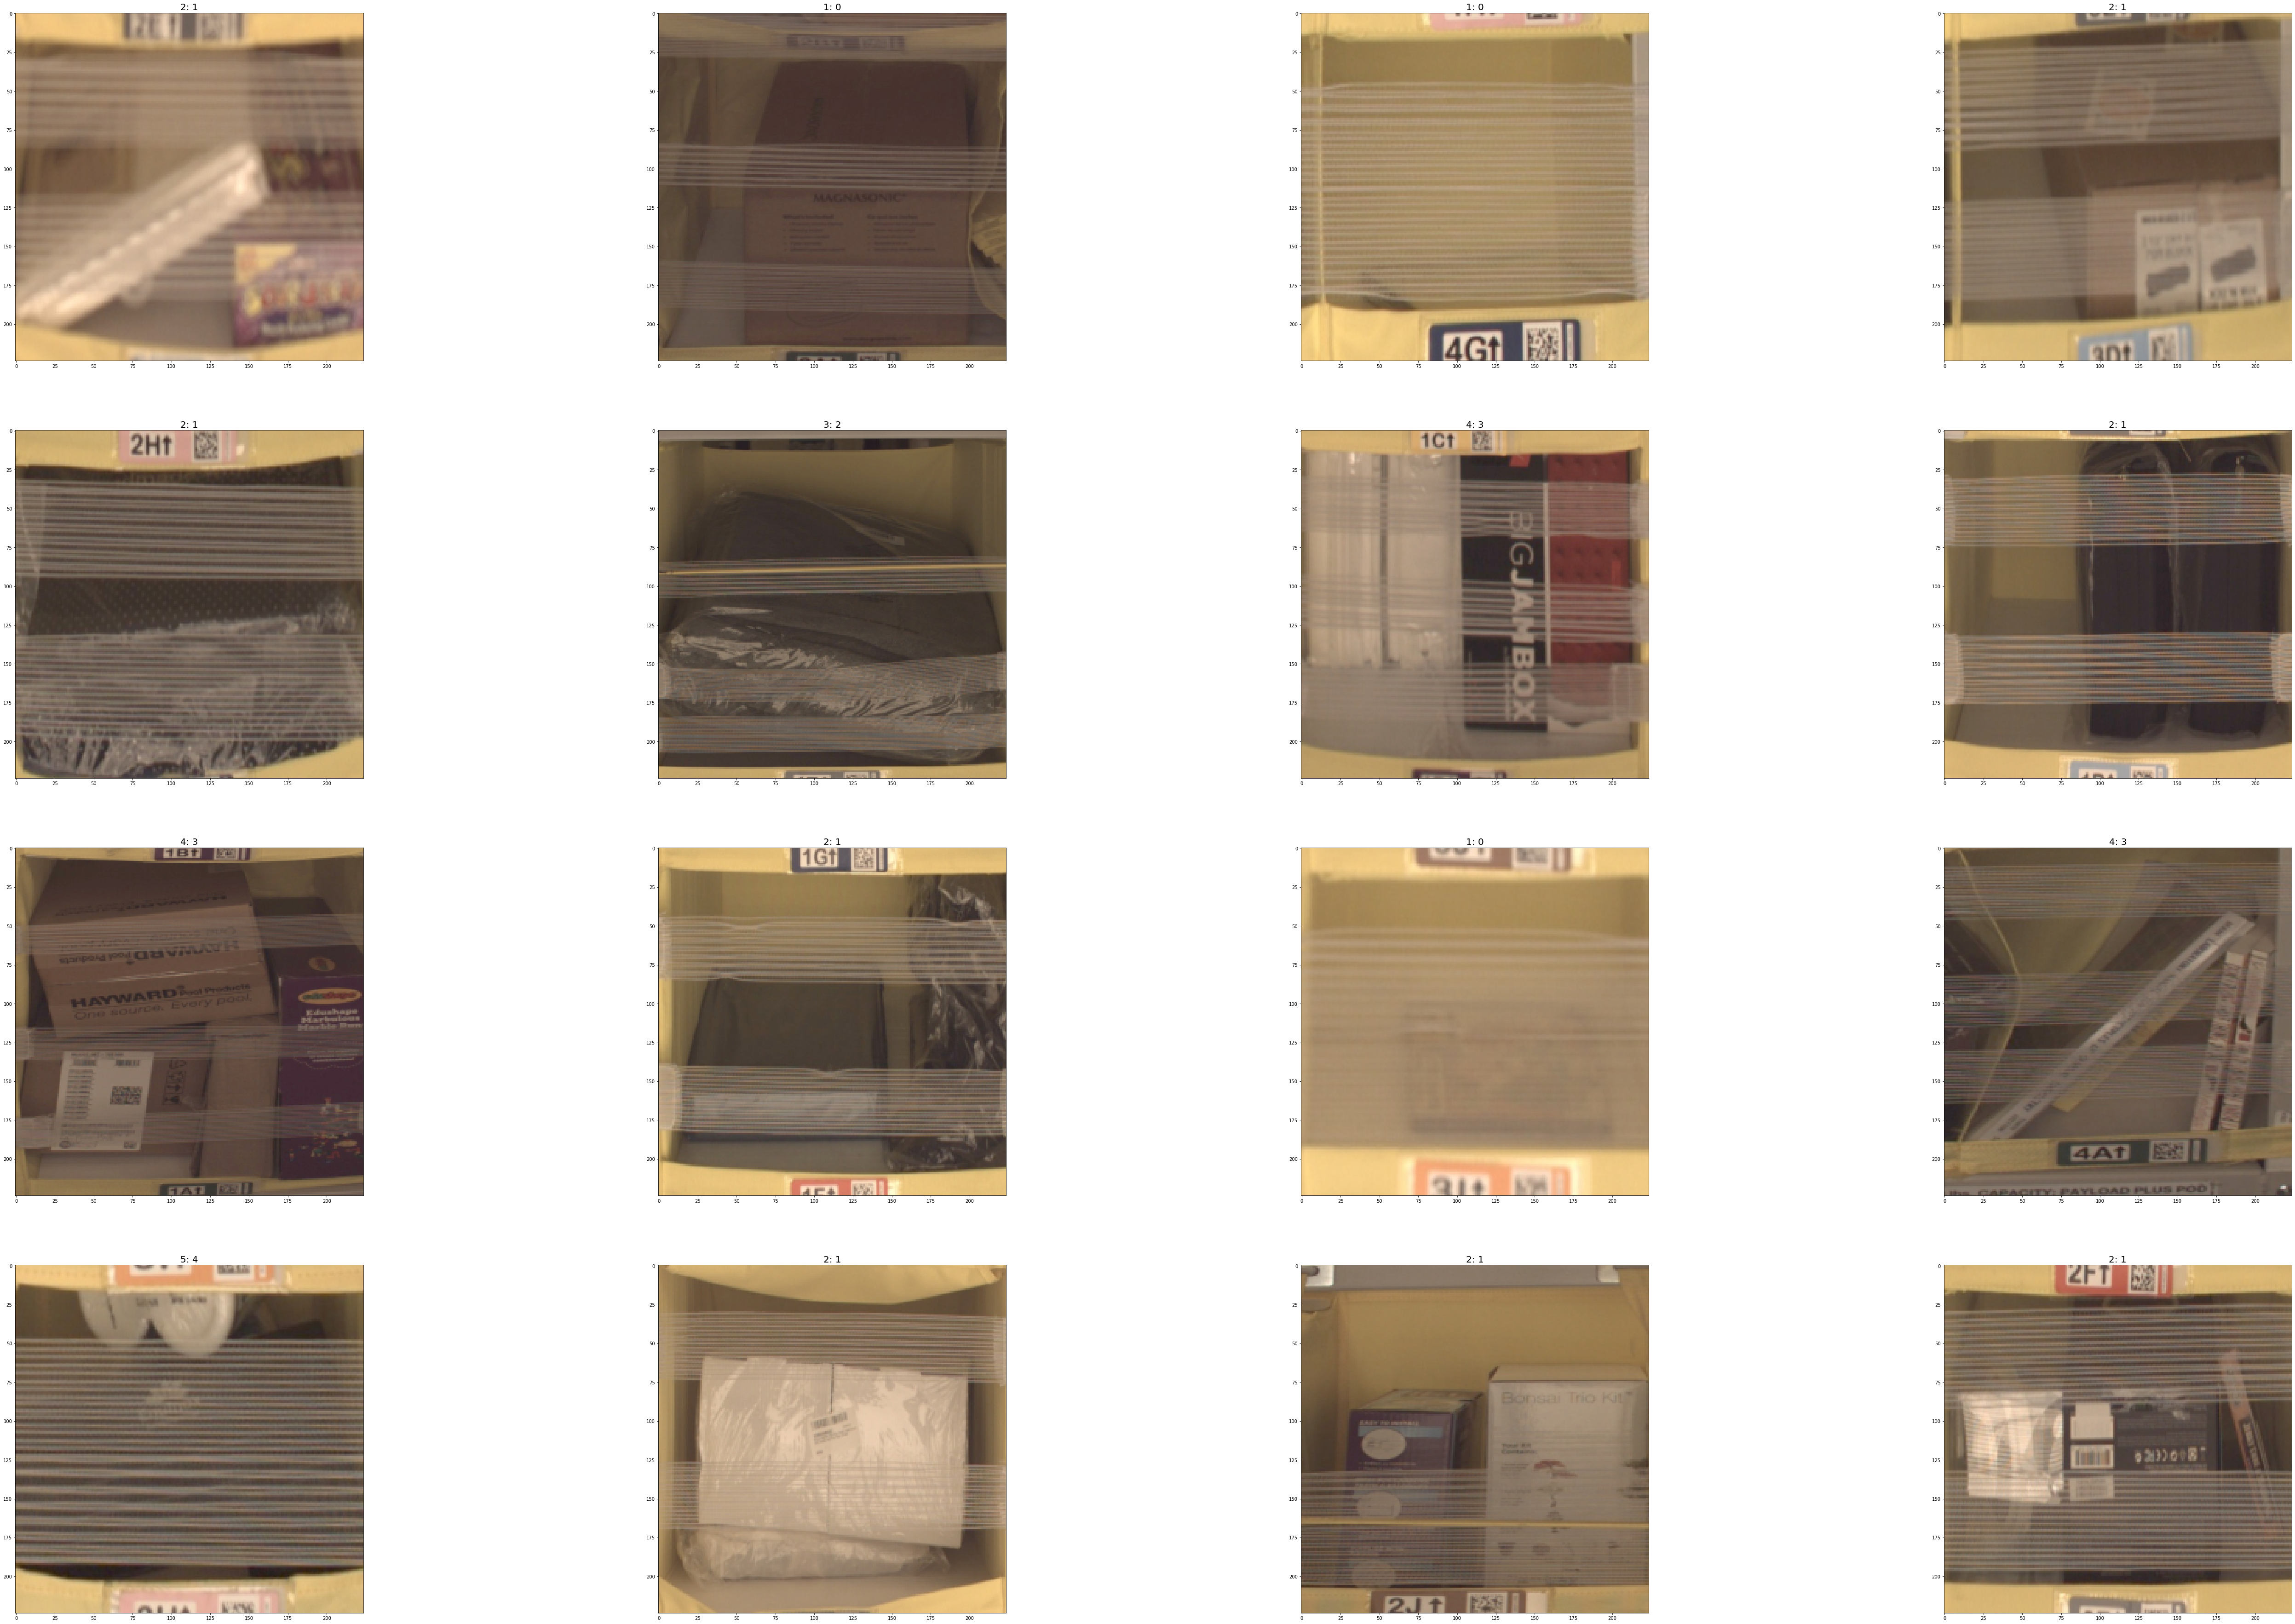

In [9]:
dataset.show_images()

In [10]:
model_list = ImagePredictor.list_models()
#model_list

We start with specifying the pretrained neural network candidates. Given such a list, AutoGluon tries to train different networks from this list to identify the best-performing candidate. This is an example of a autogluon.core.space.Categorical search space, in which there are a limited number of values to choose from.

In [9]:
models = ag.Categorical('coat_tiny', 'inception_v4', 'resnet18', 'resnet26', 'vgg16')

Similarly, we can manually specify many crucial hyper-parameters, with specific value or search space

In [19]:
batch_sizes = ag.Categorical(32, 64, 128, 256)
learning_rates = ag.Real(0.001, 0.1, log=True)
lr = ag.Categorical(1e-2, 1e-3)
hyperparameters={'model': models, 'batch_size': 64, 'lr': lr, 'epochs': 3}

In [20]:
predictor = ImagePredictor()
predictor.fit(dataset, 
              time_limit=60*120, 
              hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={'searcher': 'bayesopt', 'num_trials': 2})

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
No GPU detected/allowed, using most conservative search space.
Starting HPO experiments


modified configs(<old> != <new>): {
root.misc.seed       42 != 110
root.misc.num_workers 4 != 2
root.train.early_stop_patience -1 != 10
root.train.batch_size 32 != 64
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != coat_tiny
root.gpus            (0,) != ()
}
Saved config to /root/SageMaker-Inventory-monitoring/5c33fcd1/.trial_0/config.yaml
Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
modified configs(<old> != <new>): {
root.misc.seed       42 != 110
root.misc.num_workers 4 != 2
root.train.early_stop_patience -1 != 10
root.train.batch_size 32 != 64
root.train.lr        0.01 != 0.001
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 3
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != coat_t

ValueError: Active hyperparameter 'lr▁choice' not specified!

In [ ]:
predictor.fit_summary()

This part was performed within a ml.m5.large instance. The use of GPU equipped instance was always throwing back the following error message:
"RuntimeError: DataLoader worker (pid 186) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit." And it is impossible to increase the shared memory limit manually.

List limitations of such investigation    
-3 epochs is low, and some models can have different learning curves. In other words, we might end up selecting a model which learn fast but would have quickly converged or overfitted, and missed one which would have reach an higher accuracy given more time to train. 

-Autogluon makes use of transfer learning, therefore, the observed performance might be due to how the models have been pretrained (dataset, hyperparameters...) and not the model itself.




In [28]:
model = ag.Categorical('coat_tiny', 'inception_v4', 'resnet18', 'resnet26', 'vgg16')
lr = ag.Real(0.001, 0.1, log=True)
batch_size = ag.Categorical(32, 64, 128, 256)

ImagePredictor sets accuracy as default eval_metric for classification problems.
Reset labels to [0, 1, 2, 3, 4]
Randomly split train_data into train[1881]/validation[210] splits.
No GPU detected/allowed, using most conservative search space.
Starting HPO experiments


modified configs(<old> != <new>): {
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
root.train.epochs    200 != 3
root.gpus            (0,) != ()
root.misc.seed       42 != 235
root.misc.num_workers 4 != 2
root.img_cls.model   resnet101 != coat_tiny
}
Saved config to /root/SageMaker-Inventory-monitoring/31eac45a/.trial_0/config.yaml
Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
modified configs(<old> != <new>): {
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
root.train.lr        0.01 != 0.018930984005839497
root.train.epochs    200 != 3
root.gpus            (0,) != ()
root.misc.seed       42 != 235
root.misc.num_workers 4 != 2
root.img_cls.model   resnet101 != resnet26
}
Saved conf

Model coat_tiny created, param count:                                         5346305
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Saving Training Curve in /root/SageMaker-Inventory-monitoring/31eac45a/plot_training_curves.png


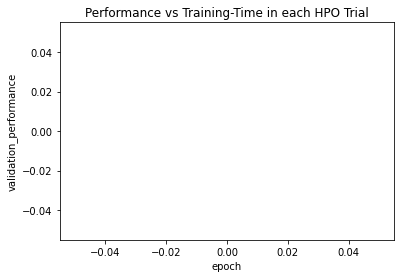

Finished, total runtime is 48.34 s


KeyError: 'estimator'

In [29]:
hyperparameters = {'model': model, 'batch_size': batch_size, 'lr': lr, 'epochs': 3}
predictor = ImagePredictor()
predictor.fit(dataset, time_limit=60*120, hyperparameters=hyperparameters,
              hyperparameter_tune_kwargs={#'searcher': 'bayesopt',
                                          'num_trials': 2})